In [1]:
# import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.linalg import expm
from scipy import linalg as la
from multiprocessing import Pool

In [2]:
def box_hamiltonian(highest_level, hbar, mass, length):
    constant_factor = np.pi ** 2 * hbar ** 2 / (2 * mass * length ** 2)
    matrix = np.zeros((highest_level, highest_level))
    for n in range(1, highest_level + 1):
        matrix[n - 1, n - 1] = n ** 2
    return np.matrix(constant_factor * matrix)

def partition_function(beta, hamiltonian):
    return np.trace(expm(-beta * hamiltonian))

def box_thermal_state(highest_level ,hbar, mass, length, beta):
    H = box_hamiltonian(highest_level, hbar, mass, length)
    return np.matrix(expm(- beta * H) / partition_function(beta, H))

def time_evolution(hamiltonian, time, hbar):
    return np.matrix(expm(-1j * hamiltonian * time / hbar))

def box_position_operator(highest_level, hbar, mass, length, time, use_mine=True):
    matrix = np.zeros((highest_level, highest_level), dtype=np.complex128)
    for n in range(1, highest_level + 1):
        En = n ** 2 * hbar ** 2 * n ** 2/ (2 * mass * length ** 2)
        for m in range(1, highest_level + 1):
            Em = m ** 2 * hbar ** 2 * m ** 2/ (2 * mass * length ** 2)
            phase = np.e ** (-1j * (Em - En) * time / hbar)
            if m == n:
                amplitude = length / 2
            else:
                if use_mine:
                    # My amplitude calculation
                    amplitude = 2 * length * (-2 * m * n + 2 * (-1) ** (m + n) * m * n) / ((m ** 2 - n **2) ** 2 * np.pi ** 2)
                else:
                    # The paper's amplitude calculation
                    amplitude = (length / np.pi ** 2) * (1 - (-1) ** (n + m)) * (1 / ((n + m) ** 2) - 1 / ((n - m) ** 2))
            matrix[n - 1, m - 1] = phase * amplitude
    return np.matrix(matrix)

def box_momentum_operator(highest_level, hbar, length):
    # Computation flawed and deprecated. Use the "trick" version instead.
    matrix = np.zeros((highest_level, highest_level), dtype=np.complex128)
    for n in range(1, highest_level + 1):
        kn = n * np.pi / length
        matrix[n - 1, n - 1] = hbar * kn
    return np.matrix(matrix)

def momentum_operator(position_operator, hamiltonian):
    # Preferred "trick" version. Only works for single particles.
    matrix = np.zeros(position_operator.shape, dtype=np.complex128)
    highest_level = position_operator.shape[0]
    for n in range(1, highest_level + 1):
        En = hamiltonian[n - 1, n - 1]
        for m in range(1, highest_level + 1):
            Em = hamiltonian[m - 1, m - 1]
            matrix[n - 1, m - 1] = (1j / 2) * (En - Em) * position_operator[n - 1, m - 1]
    return np.matrix(matrix)

def energy_expectation(highest_level, hbar, mass, length, beta):
    H = box_hamiltonian(highest_level, hbar, mass, length)
    rho = box_thermal_state(highest_level, hbar, mass, length, beta)
    return np.trace(H * rho)

In [3]:
def energy_component(index_1, index_2):
    return np.pi ** 2 * (index_1 ** 2 - index_2 ** 2)

def position_component(index_1, index_2):
    if index_1 == index_2:
        return 1 / 2
    else:
        return ((1 - (-1) ** (index_1 + index_2)) / np.pi ** 2) * (1 / (index_1 + index_2) ** 2 - 1 / (index_1 - index_2) ** 2)

def momentum_component(index_1, index_2):
    return (1j / 2) * energy_component(index_1, index_2) * position_component(index_1, index_2)
    
def paper_partition_function(highest_level, temperature):
    z_partial = []
    for i in range(highest_level):
        E = np.pi ** 2 * i ** 2
        z_partial.append(np.e ** (-E / temperature))
    return np.sum(z_partial)

def paper_box_OTOC(inputs):
    highest_level = inputs[0]
    temperature = inputs[1]
    time = inputs[2]
    energy_OTOC_n_list = []
    for n in range(highest_level):
        c_nm_list = []
        for m in range(highest_level):
            b_nmk_list = []
            for k in range(highest_level):
                E_nk = energy_component(n + 1, k + 1)
                E_km = energy_component(k + 1, m + 1)
                phase_left = np.e ** (1j * E_nk * time)
                phase_right = np.e ** (1j * E_km * time)
                x_nk = position_component(n + 1, k + 1)
                p_km = momentum_component(k + 1, m + 1)
                p_nk = momentum_component(n + 1, k + 1)
                x_km = position_component(k + 1, m + 1)
                b_nmk = -1j * (phase_left * x_nk * p_km - phase_right * p_nk * x_km)
                b_nmk_list.append(b_nmk)
            b_nmk_array = np.array(b_nmk_list)
            b_nm = np.sum(b_nmk_array)
            c_nm = b_nm * np.conj(b_nm)
            c_nm_list.append(c_nm)
        c_nm_array = np.array(c_nm_list)
        c_n = np.sum(c_nm_array)
        energy_OTOC_n = np.e ** (- np.pi ** 2 * n ** 2 / temperature) * c_n
        energy_OTOC_n_list.append(energy_OTOC_n)
    energy_OTOC_n_array = np.array(energy_OTOC_n_list)
    OTOC = np.sum(energy_OTOC_n_array) / paper_partition_function(highest_level, temperature)
    return OTOC

def postition_position_OTOC(inputs):
    # Double check this math to see if it actually makes any sense or not.
    highest_level = inputs[0]
    temperature = inputs[1]
    time = inputs[2]
    energy_OTOC_n_list = []
    for n in range(highest_level):
        c_nm_list = []
        for m in range(highest_level):
            b_nmk_list = []
            for k in range(highest_level):
                E_nk = energy_component(n + 1, k + 1)
                E_km = energy_component(k + 1, m + 1)
                phase_left = np.e ** (1j * E_nk * time)
                phase_right = np.e ** (1j * E_km * time)
                x_nk = position_component(n + 1, k + 1)
                p_km = position_component(k + 1, m + 1)
                p_nk = position_component(n + 1, k + 1)
                x_km = position_component(k + 1, m + 1)
                b_nmk = -1j * (phase_left * x_nk * p_km - phase_right * p_nk * x_km)
                b_nmk_list.append(b_nmk)
            b_nmk_array = np.array(b_nmk_list)
            b_nm = np.sum(b_nmk_array)
            c_nm = b_nm * np.conj(b_nm)
            c_nm_list.append(c_nm)
        c_nm_array = np.array(c_nm_list)
        c_n = np.sum(c_nm_array)
        energy_OTOC_n = np.e ** (- np.pi ** 2 * n ** 2 / temperature) * c_n
        energy_OTOC_n_list.append(energy_OTOC_n)
    energy_OTOC_n_array = np.array(energy_OTOC_n_list)
    OTOC = np.sum(energy_OTOC_n_array) / paper_partition_function(highest_level, temperature)
    return OTOC

def paper_box_OTOC_over_time(highest_level, temperature_array, time_array):
    inputs = []
    for i in range(len(temperature_array)):
        inputs.append((highest_level, temperature_array[i], time_array[i]))
    with Pool(5) as p:
        OTOC_list = p.map(paper_box_OTOC, inputs)
    OTOC_array = np.array(OTOC_list)
    return OTOC_array

def position_position_OTOC_over_time(highest_level, temperature_array, time_array):
    inputs = []
    for i in range(len(temperature_array)):
        inputs.append((highest_level, temperature_array[i], time_array[i]))
    with Pool(5) as p:
        OTOC_list = p.map(paper_box_OTOC, inputs)
    OTOC_array = np.array(OTOC_list)
    return OTOC_array

In [4]:
def box_OTOC_beta(highest_level, hbar, mass, length, beta, time):
    rho = box_thermal_state(highest_level, hbar, mass, length, beta)
    x = box_position_operator(highest_level, hbar, mass, length, time)
    p = box_momentum_operator(highest_level, hbar, length)
    commutator = x * p - p * x
    otoc_operator = commutator ** 2
    expectation = np.trace(rho * otoc_operator)
    return - expectation

def box_OTOC_temp(highest_level, hbar, mass, length, boltzmann, temp, time, use_mine=True):
    beta = 1 / (boltzmann * temp)
    H = box_hamiltonian(highest_level, hbar, mass, length)
    rho = box_thermal_state(highest_level, hbar, mass, length, beta)
    x = box_position_operator(highest_level, hbar, mass, length, time, use_mine=use_mine)
    x0 = box_position_operator(highest_level, hbar, mass, length, 0, use_mine=use_mine)
    p = momentum_operator(x0, H)
    commutator = x * p - p * x
    otoc_operator = commutator * commutator.H
    values = otoc_operator * rho
    # print()
    # print('NEW MATRICES')
    # print('position:')
    # print(x)
    # print('momentum:')
    # print(p)
    # print('commutation components:')
    # print(x * p)
    # print('---')
    # print(p * x)
    # print('---')
    # print(commutator)
    expectation = np.trace(values)
    return expectation

def box_OTOC_temp_over_time(highest_level, hbar, mass, length, boltzmann, temp, min_time, max_time, use_mine=True):
    delta_t = 1 / 1000
    t = np.linspace(min_time, max_time, np.int(np.round((max_time - min_time) / delta_t)))
    c = np.zeros(t.shape)
    for i in range(len(c)):
        c[i] = box_OTOC_temp(highest_level, hbar, mass, length, boltzmann, temp, delta_t * i + min_time, use_mine=use_mine)
    return t, c

In [5]:
T = np.linspace(200, 200, 1000)
t = np.linspace(0, 1, 1000)
C = paper_box_OTOC_over_time(10, T, t)

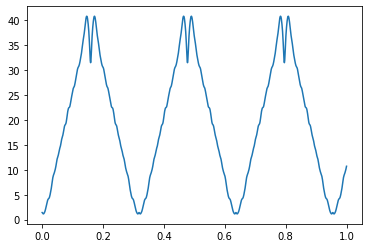

In [6]:
plt.plot(t, C)

Done with step 1.
Done with step 2.
Done with step 3.
Done with step 4.
Done with step 5.
Done with step 6.
Done with step 7.
Done with step 8.
Done with step 9.
Done with step 10.
Done with step 11.
Done with step 12.
Done with step 13.
Done with step 14.
Done with step 15.


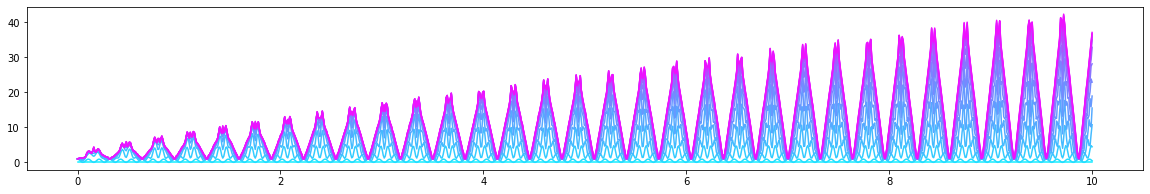

In [207]:
plt.rcParams["figure.figsize"] = (20,3)
cmap = plt.cm.cool
T = np.linspace(1, 200, 1000)
t = np.linspace(0, 10, 1000)
max_energy_level = 15
for i in range(max_energy_level):
    C = paper_box_OTOC_over_time(i, T, t)
    print('Done with step ' + str(i + 1) + '.')
    plt.plot(t, C, color = cmap(i / max_energy_level))

Done with step 1.
Done with step 2.
Done with step 3.
Done with step 4.
Done with step 5.
Done with step 6.
Done with step 7.
Done with step 8.
Done with step 9.
Done with step 10.
Done with step 11.
Done with step 12.
Done with step 13.
Done with step 14.
Done with step 15.


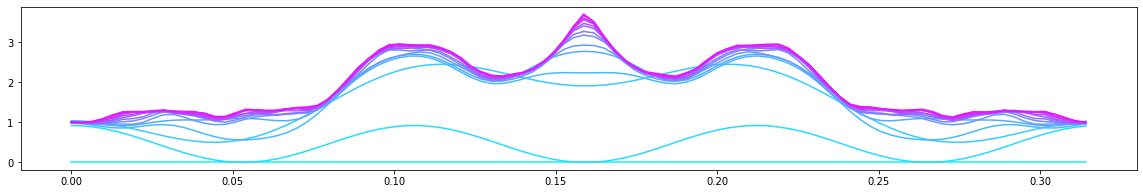

In [9]:
plt.rcParams["figure.figsize"] = (20,3)
cmap = plt.cm.cool
T = np.linspace(1, 1, 100)
for i in range(2,5):
    T = np.append(T, np.linspace(i, i, 100))
t = np.linspace(0, np.pi/10, 100)
max_energy_level = 15
for i in range(max_energy_level):
    C_x = position_position_OTOC_over_time(i, T, t)
    print('Done with step ' + str(i + 1) + '.')
    plt.plot(t, C_x, color = cmap(i / max_energy_level))

In [13]:
list(C_x).index(max(C_x))

50

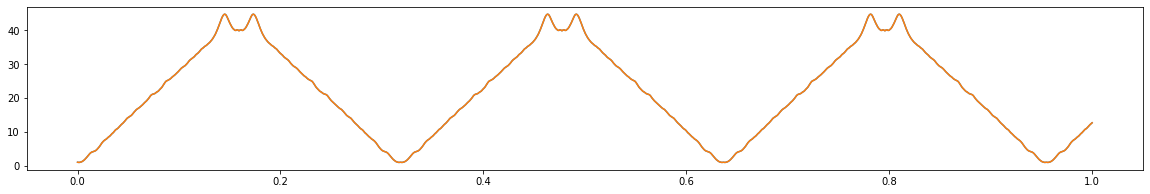

In [212]:
plt.rcParams["figure.figsize"] = (20,3)
cmap = plt.cm.cool
T = np.linspace(200, 200, 1000)
t = np.linspace(0, 1, 1000)
max_energy_level = 15
C_p = paper_box_OTOC_over_time(max_energy_level, T, t)
C_x = position_position_OTOC_over_time(max_energy_level, T, t)
plt.plot(t, C_p)
plt.plot(t, C_x)

In [25]:
def chain_hamiltonian(N, J, hz, hx):
    sx = np.array([[0, 1],[ 1, 0]])
    sy = np.array([[0, -1j],[1j, 0]])
    sz = np.array([[1, 0],[0, -1]])
    I = np.array([[1, 0],[0, 1]])
    H1 = np.zeros((2 ** N, 2 ** N))
    H2 = np.zeros((2 ** N, 2 ** N))
    H3 = np.zeros((2 ** N, 2 ** N))
    for i in range(N - 1):
        siz_1 = 1
        for j in range(N - 1):
            if i == j:
                siz_1 = np.kron(siz_1, sz)
                siz_1 = np.kron(siz_1, sz)
            else:
                siz_1 = np.kron(siz_1, I)
        H1 = H1 - J * siz_1
    for i in range(N):
        siz = 1
        six = 1
        for j in range(N):
            if i == j:
                siz = np.kron(siz, sz)
                six = np.kron(six, sx)
            else:
                siz = np.kron(siz, I)
                six = np.kron(six, I)
        H2 = H2 - hz * siz
        H3 = H3 - hx * six
    H = H1 + H2 + H3
    return H

def all_up(N):
    psi = 1
    for i in range(N):
        psi = np.kron(psi, np.array([[0], [1]]))
    return psi

def first_down(N):
    psi = np.array([[1], [0]])
    for i in range(N - 1):
        psi = np.kron(psi, np.array([[0], [1]]))
    return psi

def first_up(N):
    psi = np.array([[0], [1]])
    for i in range(N - 1):
        psi = np.kron(psi, np.array([[1], [0]]))
    return psi

def ss_rho(psi):
    return np.outer(psi, psi)

def partial_trace(rho, keep, dims, optimize=False):
    """
    Calculate the partial trace

    ρ_a = Tr_b(ρ)

    Parameters
    ----------
    ρ : 2D array
        Matrix to trace
    keep : array
        An array of indices of the spaces to keep after
        being traced. For instance, if the space is
        A x B x C x D and we want to trace out B and D,
        keep = [0,2]
    dims : array
        An array of the dimensions of each space.
        For instance, if the space is A x B x C x D,
        dims = [dim_A, dim_B, dim_C, dim_D]

    Returns
    -------
    ρ_a : 2D array
        Traced matrix
    """
    keep = np.asarray(keep)
    dims = np.asarray(dims)
    Ndim = dims.size
    Nkeep = np.prod(dims[keep])

    idx1 = [i for i in range(Ndim)]
    idx2 = [Ndim+i if i in keep else i for i in range(Ndim)]
    # print(np.tile(dims,2))
    rho_a = rho.reshape(np.tile(dims,2))
    # rho_a = rho.reshape((2, 2, 2, 2, 2, 2, 2, 2))
    rho_a = np.einsum(rho_a, idx1+idx2, optimize=optimize)
    return rho_a.reshape(Nkeep, Nkeep)

def vn_entropy(rho):
    log = la.logm(rho) / np.log(2)
    R = np.matmul(rho, log)
    # print(np.trace(rho))
    S = - np.trace(R)
    return(S)

def information_subregion(rho, num_keep):
    size = int(np.round(np.log2(len(rho))))
    ref_keep = [size - 1]
    sub_keep = []
    jnt_keep = []
    dims = []
    for i in range(size):
        dims.append(2)
    for i in range(num_keep):
        sub_keep.append(i)
    for i in range(size):
        if i in ref_keep or i in sub_keep:
            jnt_keep.append(i)
    reference = partial_trace(rho, ref_keep, dims)
    subregion = partial_trace(rho, sub_keep, dims)
    joint = partial_trace(rho, jnt_keep, dims)
    ref_S = vn_entropy(reference)
    sub_S = vn_entropy(subregion)
    jnt_S = vn_entropy(joint)
    # print(reference)
    # print(ref_S)
    # print(subregion)
    # print(sub_S)
    # print(joint)
    # print(jnt_S)
    return np.real(ref_S + sub_S - jnt_S)

def information_pointwise(rho, qubits_considered):
    size = int(np.round(np.log2(len(rho))))
    dims = []
    ref_keep = [size - 1]
    info_results = []
    for i in range(size):
        dims.append(2)
    for l in qubits_considered:
        sub_keep = [l]
        jnt_keep = []
        for i in range(size):
            if i in ref_keep or i in sub_keep:
                jnt_keep.append(i)
        reference = partial_trace(rho, ref_keep, dims)
        subregion = partial_trace(rho, sub_keep, dims)
        joint = partial_trace(rho, jnt_keep, dims)
        ref_S = vn_entropy(reference)
        sub_S = vn_entropy(subregion)
        jnt_S = vn_entropy(joint)
        info_results.append(np.real(ref_S + sub_S - jnt_S))
    return info_results

def evolve(hamiltonian, time):
    U = la.expm(- 1j * time * hamiltonian)
    return la.expm(- 1j * time * hamiltonian)

def info_helper(inputs):
    rho = inputs[0]
    num_keep = inputs[1]
    H = inputs[2]
    time = inputs[3]
    U = np.matrix(evolve(H, time))
    # print(U)
    rho_t = np.array(np.matmul(U, np.matmul(rho, U.H)))
    # print(rho_t)
    info = information_subregion(rho_t, num_keep)
    # print(info)
    return info

def pointwise_helper(inputs):
    rho = inputs[0]
    qubits_considered = inputs[1]
    H = inputs[2]
    time = inputs[3]
    U = np.matrix(evolve(H, time))
    # print(U)
    rho_t = np.array(np.matmul(U, np.matmul(rho, U.H)))
    # print(rho_t)
    info = information_pointwise(rho_t, qubits_considered)
    # print(info)
    return info

def mutual_information_over_time(total_number_qubits, subregion_number_qubits, time_array):
    N = total_number_qubits
    l = subregion_number_qubits
    H = np.kron(chain_hamiltonian(N, 1, 0, 1), np.array([[1, 0], [0, 1]]))
    psi1 = all_up(N)
    psi2 = first_down(N)
    psi3 = first_up(N)
    ref_down = np.array([[1], [0]])
    ref_up = np.array([[0], [1]])
    big_bell = (1 / np.sqrt(2)) * (np.kron(psi1, ref_down) + np.kron(psi2, ref_up))
    # big_bell = np.kron(psi1, ref_down)
    rho = np.outer(big_bell, big_bell)
    inputs = []
    for i in range(len(time_array)):
        inputs.append((rho, l, H, time_array[i]))
    with Pool(5) as p:
        info_list = p.map(info_helper, inputs)
    info_array = np.array(info_list)
    return info_array

def pointwise_mutual_information_over_time(total_number_qubits, qubits_considered, time_array):
    N = total_number_qubits
    H = np.kron(chain_hamiltonian(N, 1, 0, 1), np.array([[1, 0], [0, 1]]))
    psi1 = all_up(N)
    psi2 = first_down(N)
    psi3 = first_up(N)
    ref_down = np.array([[1], [0]])
    ref_up = np.array([[0], [1]])
    big_bell = (1 / np.sqrt(2)) * (np.kron(psi1, ref_down) + np.kron(psi2, ref_up))
    rho = np.outer(big_bell, big_bell)
    inputs = []
    for i in range(len(time_array)):
        inputs.append((rho, qubits_considered, H, time_array[i]))
    with Pool(5) as p:
        info_list = p.map(pointwise_helper, inputs)
    info_array = np.array(info_list)
    return np.transpose(info_array)

done with step 1
done with step 2
done with step 3
done with step 4
done with step 5
done with step 6
done with step 7
done with step 8


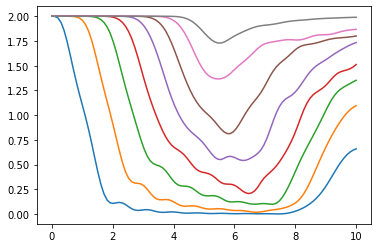

In [17]:
min_time = 0
max_time = 10
delta_t = 0.1
t = np.linspace(min_time, max_time, int(np.round((max_time - min_time) / delta_t)))
info_results = []
for i in range(1, 9):
    I = mutual_information_over_time(9, i, t)
    info_results.append(I)
    print('done with step ' + str(i))
    plt.plot(t, I)

In [84]:
min_time = 0
max_time = 200
delta_t = 1
t = np.linspace(min_time, max_time, int(np.round((max_time - min_time) / delta_t)))

info_points = pointwise_mutual_information_over_time(8, [0, 1, 2, 3, 4, 5, 6, 7], t)

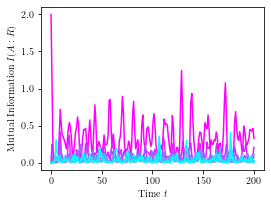

In [85]:
min_time = 0
max_time = 200
delta_t = 1
t = np.linspace(min_time, max_time, int(np.round((max_time - min_time) / delta_t)))
rc('font',**{'family':'serif'})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (4,3)
plt.xlabel('Time $t$')
plt.ylabel('Mutual Information $I(A:R)$')
for i in range(8):
    plt.plot(t, info_points[i], color=cmap(1-i/7))
plt.savefig("test.svg", format="svg")
plt.show()

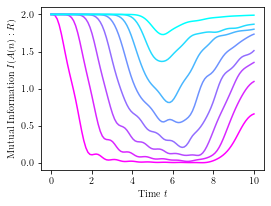

In [77]:
plt.rcParams["figure.figsize"] = (4,3)
plt.xlabel('Time $t$')
plt.ylabel('Mutual Information $I(A(n):R)$')
cmap = plt.cm.cool
min_time = 0
max_time = 10
delta_t = 0.1
t = np.linspace(min_time, max_time, int(np.round((max_time - min_time) / delta_t)))
for i in range(0, 8):
    plt.plot(t, info_results[i], color=cmap(1-i/7))
plt.savefig("test.svg", format="svg")

In [73]:
len(info_results)

8